# Lab: Gene regulatory network inference

In this lab you will apply a few GRN inference methods to data and compare the resulting GRN predictions with different metrics.

The lab consists of the sections:
1. Installation
2. Obtain the datasets
3. GRN inference
4. Selecting the number of interactions in inferred GRNs
5. Consensus network
6. Comparing topological properties
7. Comparison with gold standard network
8. Plotting GRNs
9. Biological interpretation

## 1. Installation
To run this lab you need to have Python 3 and the following packages installed:
- Pandas
- NumPy
- scikit-learn
- Matplotlib
- seaborn
- networkx

We have provided a conda environment for this lab which is optional to use for installing the packages for the lab. Download "environment_grn_lab.yml" from the course Canvas page and run "conda env create -f environment_grn_lab.yml".

You should also download the file GENIE3.py from the course Canvas page and place it in your working directory.

Start with importing the packages.

## 2. Obtain the datasets

For this lab we will use a synthetic dataset which was generated using [GeneNetWeaver](https://academic.oup.com/bioinformatics/article/27/16/2263/254752?login=false). Download the following files from the course Canvas page.
- GRN_lab_gene_expression_data.csv - Synthetic gene expression data for 500 genes. The dataset contains 500 samples where one gene has been perturbed in each sample.
- GRN_lab_regulators.csv - A list of regulators.
- GRN_lab_signed_gold_standard.csv - A gold standard network. This network was used for generating the synthetic gene expression data.

Read the gene expression data into a Pandas DataFrame and the list of regulators into a NumPy array by running the code below. Adjust the file paths to your file system.

In [1]:
import pandas as pd
import numpy as np

## Gene expression data
exp = pd.read_csv('GRN_lab_gene_expression_data.csv', index_col=0)#.iloc[:, :200]

print(f"Number of possible target genes: {exp.shape[1]}")
print(f"Number of samples: {exp.shape[0]}")

## Regulators
regulators = pd.read_csv('GRN_lab_regulators.csv',
                  header=None).values.flatten()
print(f"Number of regulators: {len(regulators)}")

Number of possible target genes: 500
Number of samples: 500
Number of regulators: 89


## 3. GRN inference
In this section you will apply a few GRN inference methods. We have included implementations of three methods: absolute value of the Pearson's correlation coefficient (PCC), [GENIE3](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0012776), and LASSO. All three methods scores interactions between regulators (often transcription factors; TFs) and their target genes using gene expression data. GENIE3 and LASSO are both regression based method using different types of feature selection. GENIE3 is a tree-based ensemble method and LASSO is a type of regularized linear regression. 

To your help you we have have provided the following functions:
- run_pcc - returns the absolute value of the PCC for each regulator-target gene pair.
- run_genie3 - returns a confidence score for each regulator-target gene pair.
- run_lasso - returns the abosulute value of the estimated coefficients for each regulator-target gene pair.

The output of all functions are a confidence score matrix for interactions between regulators (rows) and target genes (columns). For this lab we consider the metrics obtained from each GRN inference methods to be a confidence score for each regulator-target gene interaction i.e. how likely the interaction is to occur. 

Start with running the cell below.

In [2]:
# Absolute value of the PCC
def run_pcc(exp, tfs):
    # Calculate correlations
    corrmat = exp.corr().abs()
    confidence_scores = corrmat.loc[tfs, :]
    return confidence_scores

# GENIE3
def run_genie3(exp, tfs, ntrees=100):
    # ntrees are set to 100 to reduce computation time.
    # Import GENIE3 functions. GENIE3.py file need to be placed in working directory.
    from GENIE3 import GENIE3

    # Run GENIE3
    vim = GENIE3(exp.values, 
                 gene_names=exp.columns.values.tolist(), 
                 regulators=tfs.tolist(), 
                 ntrees=ntrees)
    confidence_scores = pd.DataFrame(vim, index=exp.columns, columns=exp.columns).loc[tfs, :]
    return confidence_scores

# LASSO
def run_lasso(exp, tfs, cv=3):
    # Import LASSO. Stop warnings from being printed.
    import warnings
    warnings.filterwarnings("ignore")
    from sklearn.linear_model import LassoCV

    # Format data
    targets_exp = exp.T.values
    tfs_exp = exp.loc[:, tfs].values

    # Run LASSO with cross validation to select best model parameters.
    model = LassoCV(n_jobs=-1, cv=cv)

    # Fit one model for each target gene.
    coef_mat = np.empty((targets_exp.shape[0], tfs_exp.shape[1]))
    for i, j in enumerate(targets_exp):
        if i%100 == 0:
            print('Working on target number', i)
        model.fit(tfs_exp, targets_exp[i])
        coef_mat[i] = model.coef_

    # Format confidence score matrix and return the absolute value of all coefficients.
    confidence_scores = pd.DataFrame(coef_mat, index=exp.columns, columns=tfs).T.abs()
    return confidence_scores

Now you can run the GRN inference methods. An easy way to store the inferred GRNs for subsequent processing is to use a dictionary.

In [3]:
# Run PCC
grns_scores = {}
grns_scores['PCC'] = run_pcc(exp, regulators)

,hipA,hipB,ihfB,yeiL,tdcA,tdcR,yiaJ,ompR,bolA,csgD,...,lldP,rfaY,betB,fliT,rpsS,fucK,rpmC,wzb,nemA,prpD
arcA,0.080573,0.015678,0.031990,0.088718,0.039299,0.034481,0.010955,0.033238,0.006733,0.003185,...,0.305528,0.009476,0.417128,0.048657,0.141017,0.003390,0.056532,0.012015,0.032632,0.080441
ascG,0.033339,0.011857,0.037420,0.040001,0.019709,0.038613,0.009065,0.026632,0.054765,0.015743,...,0.041201,0.019870,0.005459,0.051628,0.065479,0.045676,0.013885,0.022122,0.029069,0.003807
asnC,0.004092,0.045441,0.023317,0.090187,0.019635,0.046327,0.009678,0.050300,0.037683,0.045165,...,0.000006,0.036366,0.003173,0.034637,0.015324,0.000411,0.030390,0.019883,0.031771,0.055216
baeR,0.017692,0.036308,0.062662,0.007058,0.027523,0.019183,0.012178,0.014862,0.030696,0.033264,...,0.033716,0.003347,0.079104,0.078120,0.048729,0.003616,0.083982,0.031858,0.000677,0.041294
betI,0.038636,0.040155,0.001730,0.055885,0.058349,0.038609,0.019643,0.038149,0.069182,0.054924,...,0.014714,0.049471,0.272135,0.013217,0.037440,0.026143,0.183229,0.007208,0.028660,0.031904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
uxuR,0.017567,0.047054,0.018369,0.047364,0.063203,0.015162,0.191878,0.053587,0.076380,0.007130,...,0.056625,0.059142,0.011379,0.008829,0.032455,0.219120,0.015274,0.031267,0.058980,0.167558
xylR,0.014782,0.068917,0.022958,0.145854,0.082871,0.045244,0.138501,0.175845,0.080273,0.035463,...,0.051127,0.036481,0.056773,0.088306,0.051249,0.141203,0.004518,0.032938,0.029679,0.205164
ydeO,0.002158,0.045595,0.011227,0.039420,0.067356,0.005965,0.060683,0.032746,0.021724,0.011689,...,0.091300,0.037146,0.038097,0.020529,0.030810,0.076725,0.046496,0.094874,0.029798,0.012072
yiaJ,0.026414,0.008783,0.039934,0.075326,0.108021,0.028481,1.000000,0.252763,0.118462,0.022106,...,0.019994,0.076873,0.002565,0.099403,0.039337,0.204927,0.025341,0.013933,0.038584,0.154237


In [4]:
# Run GENIE3
grns_scores['genie3'] = run_genie3(exp, regulators)

/mnt/data/hong/courses/SystemBiology/GRN/GENIE3.py:71: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if regulators is not 'all':
/mnt/data/hong/courses/SystemBiology/GRN/GENIE3.py:82: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if maxcount is not 'all' and not isinstance(maxcount,int):
/mnt/data/hong/courses/SystemBiology/GRN/GENIE3.py:219: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if regulators is not 'all':
/mnt/data/hong/courses/SystemBiology/GRN/GENIE3.py:230: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if tree_method is not 'RF' and tree_method is not 'ET':
/mnt/data/hong/courses/SystemBiology/GRN/GENIE3.py:230: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if tree_method is not 'RF' and tree_method is not 'ET':
/mnt/data/hong/courses/SystemBiology/GRN/GENIE3.py:233: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if K is not 'sqrt' and K is not 'all' and not isi

Tree method: RF
K: sqrt
Number of trees: 100


running single threaded jobs
Gene 1/500...
Gene 2/500...
Gene 3/500...
Gene 4/500...
Gene 5/500...
Gene 6/500...
Gene 7/500...
Gene 8/500...
Gene 9/500...
Gene 10/500...
Gene 11/500...
Gene 12/500...
Gene 13/500...
Gene 14/500...
Gene 15/500...
Gene 16/500...
Gene 17/500...
Gene 18/500...
Gene 19/500...
Gene 20/500...
Gene 21/500...
Gene 22/500...
Gene 23/500...
Gene 24/500...
Gene 25/500...
Gene 26/500...
Gene 27/500...
Gene 28/500...
Gene 29/500...
Gene 30/500...
Gene 31/500...
Gene 32/500...
Gene 33/500...
Gene 34/500...
Gene 35/500...
Gene 36/500...
Gene 37/500...
Gene 38/500...
Gene 39/500...
Gene 40/500...
Gene 41/500...
Gene 42/500...
Gene 43/500...
Gene 44/500...
Gene 45/500...
Gene 46/500...
Gene 47/500...
Gene 48/500...
Gene 49/500...
Gene 50/500...
Gene 51/500...
Gene 52/500...
Gene 53/500...
Gene 54/500...
Gene 55/500...
Gene 56/500...
Gene 57/500...
Gene 58/500...
Gene 59/500...
Gene 60/500...
Gene 61/500...
Gene 62/500...
Gen

,hipA,hipB,ihfB,yeiL,tdcA,tdcR,yiaJ,ompR,bolA,csgD,...,lldP,rfaY,betB,fliT,rpsS,fucK,rpmC,wzb,nemA,prpD
arcA,0.012169,0.012331,0.010293,0.010130,0.009825,0.015032,0.010608,0.009096,0.005641,0.012541,...,0.061884,0.009760,0.060858,0.008531,0.020052,0.005519,0.010090,0.008549,0.011201,0.006739
ascG,0.010982,0.009748,0.010092,0.007008,0.008490,0.008908,0.009444,0.009441,0.009109,0.010956,...,0.005218,0.010238,0.007453,0.019216,0.015510,0.007382,0.011179,0.010922,0.009912,0.007800
asnC,0.008983,0.009739,0.011383,0.012462,0.009431,0.011511,0.008418,0.013438,0.010727,0.011593,...,0.038385,0.009619,0.007727,0.011401,0.011182,0.008575,0.008481,0.009574,0.008338,0.008259
baeR,0.013105,0.008871,0.010121,0.009629,0.009926,0.008589,0.013165,0.009647,0.012880,0.010051,...,0.005879,0.011429,0.012948,0.012721,0.009071,0.008104,0.012529,0.008621,0.011936,0.008426
betI,0.013546,0.011041,0.007765,0.015250,0.008617,0.011160,0.007107,0.010441,0.012913,0.011292,...,0.009014,0.008772,0.033810,0.012868,0.012464,0.006229,0.022091,0.013397,0.009738,0.008143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
uxuR,0.010828,0.007333,0.008643,0.015543,0.015179,0.009658,0.013082,0.008641,0.011729,0.008529,...,0.004113,0.006219,0.010012,0.023799,0.009008,0.010766,0.008700,0.011499,0.012824,0.009171
xylR,0.013784,0.012778,0.009421,0.016398,0.013366,0.010478,0.010199,0.016642,0.013736,0.010524,...,0.046082,0.009321,0.008827,0.016109,0.009885,0.009344,0.011279,0.009494,0.011108,0.016552
ydeO,0.008564,0.008821,0.011817,0.010595,0.013121,0.014453,0.009975,0.009100,0.009247,0.013560,...,0.013585,0.008773,0.007455,0.008390,0.008396,0.012985,0.011874,0.013827,0.011802,0.006885
yiaJ,0.008112,0.009439,0.007950,0.009724,0.014005,0.010596,0.000000,0.027658,0.010212,0.013979,...,0.004661,0.011350,0.012163,0.015711,0.011326,0.012519,0.013464,0.010944,0.008091,0.011591


In [5]:
# Run LASSO
grns_scores['lasso'] = run_lasso(exp, regulators)

Working on target number 0
Working on target number 100
Working on target number 200
Working on target number 300
Working on target number 400


Next we will convert the matrices with confidence scores to sparse format i.e. from a confidence score matrix to a three column table. 

| regulator  | target | confidence |
|:-:|:-:|:-:|
| regulator1 | target_gene1 | score |
| regulator3 | target_gene2 | score |
| regulator2 | target_gene3 | score |
| regulator1 | target_gene1 | score |


We will also remove autoregulation (i.e. a regulator which regulates it's own expression) from the networks, remove all interactions with confidence score = 0, and sort the interactions on confidence score.

You can use the provided function "format_network_sparse" for formatting the networks. You should print out how many interactions each network contains after formatting.

In [6]:
def format_network_sparse(confidence_scores):
    grn = confidence_scores.reset_index().melt(id_vars=['index'])
    grn.columns = ['regulator', 'target', 'confidence']
    
    # Remove autoregulation
    grn = grn[grn.regulator != grn.target]
    
    # Sort interactions according to confidence
    grn = grn.sort_values(by='confidence', ascending=False)
    
    # Remove interactions with confidence score 0
    grn = grn[grn['confidence'] != 0]
    return grn

# Adjust the code below to format all GRNs to sparse format.
grns = {}
grns['PCC'] = format_network_sparse(grns_scores['PCC'])
grns['genie3'] = format_network_sparse(grns_scores['genie3'])
grns['lasso'] = format_network_sparse(grns_scores['lasso'])

## 4. Selecting the number of interactions in inferred GRNs

The number of interactions in predicted GRNs are often set by either setting a threshold on the number of interactions or setting a threshold on the confidence score. These thresholds are often arbitrarily determined but there are some properties that can be considered when selecting a threshold. We will use two approaches:
- Selecting a threshold by comparing the average outdegree for different network cutoffs.
- Selecting a threshold by maximizing the pairwise correlation between predicted outdegrees from multiple GRN inference methods.

An essential step for using these methods is to calculate the outdegree of all regulators in the GRNs. This can be done using the methods "group_by" and "count" from Pandas. You can use the provided function "get_regulator_outdegree" which generates a pandas DataFrame with the outdegree for each regulator.

In [12]:
def get_regulator_outdegree(grn):
    regulator_outdegree = grn[['regulator', 'target']].groupby('regulator').count()
    return regulator_outdegree

regulator_outdegrees = get_regulator_outdegree(grns['PCC'])
regulator_outdegrees_genie3 = get_regulator_outdegree(grns['genie3'])
regulator_outdegrees_lasso = get_regulator_outdegree(grns['lasso'])
np.argmin([np.mean(regulator_outdegrees), np.mean(regulator_outdegrees_genie3), np.mean(regulator_outdegrees_lasso)])

## lasso has the lowest avg.out-degree

2

**1. Selecting a threshold by comparing the average outdegree for different network cutoffs**

Here you should calculate the average outdegree for each GRN using different cutoffs on the number of interactions in the networks. For example you can start with calculating the average outdegree for the maximum number of interactions and then gradually decrease the threshold, continuously selecting the interactions with the highest confidence score.

In [39]:
max_interaction = len(grns['lasso'].index)
## 2510
## average out-degree should be small
ninteraction = max_interaction
threshold = ninteraction
grn_lasso = grns['lasso']
grn_lasso = grn_lasso.sort_values(by='confidence', ascending=False).head(ninteraction)
mean_regulator_outdegrees = np.mean(get_regulator_outdegree(grn_lasso))
step = 1
i = 0
## yield mean_reg_oudegree
## and visualize, maybe find the inflection point

def yeild_avg_out_degree(ninteraction, grn_lasso, mean_regulator_outdegrees, step):
    while ninteraction > 0:
        ninteraction = ninteraction - step
        grn_lasso = grn_lasso.sort_values(by='confidence', ascending=False).head(ninteraction)
        mean_regulator_outdegree = np.mean(get_regulator_outdegree(grn_lasso))
        # i = i + mean_regulator_outdegree < mean_regulator_outdegrees
        # if mean_regulator_outdegree < mean_regulator_outdegrees:
        #     threshold = ninteraction
        mean_regulator_outdegrees = np.min([mean_regulator_outdegree, mean_regulator_outdegrees])
        yield mean_regulator_outdegrees
mros = yeild_avg_out_degree(ninteraction, grn_lasso, mean_regulator_outdegrees, step)
## to list by list

In [40]:
mros_list = list(mros)

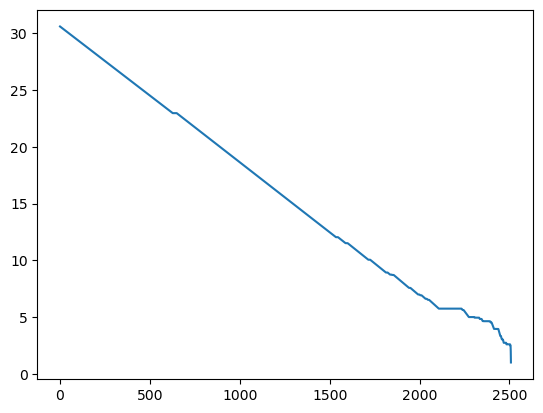

In [43]:
from matplotlib import pyplot as plt
plt.plot(mros_list)

**2. Selecting a threshold by maximizing the pairwise correlation between predicted outdegrees from multiple GRN inference methods**

Here, you should calculate the average pairwise correlation between regulator outdegrees from different GRN predictions (previously described [here](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-03987-y)). We have provided a function "avg_pairwise_correlation_outdegree" which calculates the pairwise correlation between a set of GRNs for a specified number of interactions in the netẃorks. This function takes two parameters as input: 1) a dictionary with GRNs, 2) the number of interactions to use from the networks. 

Calculate the pairwise correlation for different number of interactions in the networks by changing the parameter network_cutoff. Lastly, you can plot the average pairwise correlation vs the network cutoff (using e.g. plot from matplotlib.pyplot).

The optimal threshold is were the maximum average pairwise correlation is achieved.

In [ ]:
import matplotlib.pyplot as plt

def avg_pairwise_correlation_outdegree(grns, network_cutoff):
    # Count regulator outdegrees for a specified network cutoff
    regulator_outdegrees = []
    for grn_name in grns:
        grn_subset = grns[grn_name].iloc[:network_cutoff, :]
        ods = get_regulator_outdegree(grn_subset)
        ods.columns = [grn_name]
        regulator_outdegrees += [ods]
    regulator_outdegrees = pd.concat(regulator_outdegrees, axis=1)
    
    # Calculate pairwis correlation
    pair_corr = regulator_outdegrees.corr().values[np.triu_indices(len(grns.keys()), k=1)]
    return pair_corr.mean()

# Run function for a range of network cutoffs
pair_corr = avg_pairwise_correlation_outdegree(grns, network_cutoff=10000)

# Plot average pairwise correlation vs network cutoff
# plt.plot(x, y)

**3. Now you should select a network cutoff and change your networks accordingly.**

In [ ]:
# Below is some example code.
network_cutoff =
grns['PCC'] = grn.iloc[:network_cutoff, :]

## 5. Consensus network

Many GRN inference methods have different performance on different datasets. Combining GRNs of multiple methods can result in more stable predictions across datasets. Therefore, using an ensemble approach can be a good idea if you are unsure of which method to apply. There are multiple approaches for making consensus networks. Two options are:
1. Selecting interactions which are present in multiple inferred GRNs.
2. Ranking interactions based on confidence scores and select the top interactions based on average ranking (described [here](https://www.nature.com/articles/nmeth.2016)).

In this lab we suggest that you use the first approach to make a consensus network. You can make multiple networks by setting that interactions should be present in at least two or three GRN predictions. To your help we have provided a function "create_edge_matrix" which transforms a GRN in sparse format to an interaction matrix with 0 (no interaction) and 1 (interaction).

In [ ]:
def create_edge_matrix(grn):
    grn_mat = grn.pivot(columns='target', index='regulator', values='confidence').fillna(0)
    grn_mat[grn_mat > 0] = 1
    return grn_mat

grn_mat = create_edge_matrix(grns['PCC']).reindex(index=regulators, columns=exp.columns).fillna(0)
grn_mat

# Make consensus network
#consensus_grn =

# Store consensus network in your GRN dictionary
#grns['consensus'] = consensus_grn

## 6. Comparing topological properties
In this section you will explore different topological properties of your GRNs. We will use networkx for this and a good first step is to create networkx Graphs with your GRNs. Below is some code which creates networkx graphs from a dictionary with GRNs and stores the GRN graphs in another dictionary.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

grn_graphs = {}
for grn_name, grn in grns.items():
    grn_graphs[grn_name] = nx.from_pandas_edgelist(
        grn, 
        source='regulator', 
        target='target',
        create_using=nx.DiGraph)
grn_graphs

### Outdegree distribution

Above we used pandas and the methods group_by and count to calculate outdegrees. Networkx has a specific method, "out_degree", for this purpose. This function calculates the outdegree of all nodes in the network but nodes which are not regulators will obtain an outdegree of 0. This function can be used as:

In [ ]:
grn_g = grn_graphs['PCC']
dict(grn_g.out_degree)

What is the outdegree distribution of your predicted GRNs? First, calculate the outdegrees for all regulators and then plot a histogram to show the distribution of outdegrees. Below is some code that can be adjusted to plot the distribution.

In [ ]:
# Below is some example code.
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=len(grn_graphs.keys()), figsize=(12, 3))
for i, grn_name in enumerate(grn_graphs):
    # Make a list with all outdegrees here.
    outdegrees = 

    # Plot histograms
    ax[i].hist(outdegrees, bins=50)
    ax[i].set_title(grn_name)

The oudegree distribution of GRNs are generally assumed to follow power-law. Does the outdegree distribution of your inferred GRNs follow power-law?

This can be checked by plotting the cumulative distribution vs the outdegree. If the log(cumulative distribution) vs log(outdegree) is a straight line the distribution is approximately power-law.

The code below can help you with this problem.

In [ ]:
grn_g = grn_graphs['PCC']

# Sort outdegrees
sorted_outdegree = np.sort(list(dict(grn_g.out_degree).values()))
sorted_outdegree = sorted_outdegree[sorted_outdegree != 0][::-1]

# Get cumulative distribution
cumulative_distribution = np.arange(1, len(sorted_outdegree) + 1)

# Plot cumulative distributin vs outdegree on log-log scale


Lastly, you can check how well the regulator outdegrees correlate between different inferred GRNs. Below we have provided some code that will create a pandas DataFrame with regulator outdegrees for multiple GRNs and plot a heatmap with the outdegree correlations.

In [ ]:
def get_regulator_outdegrees(grn_graphs):
    regulator_outdegrees = []
    for grn_name in grn_graphs:
        regulator_outdegrees += [pd.Series(dict(grn_graphs[grn_name].out_degree)).rename(grn_name)]

    regulator_outdegrees = pd.concat(regulator_outdegrees, axis=1).fillna(0)
    return regulator_outdegrees

regulator_outdegrees = get_regulator_outdegrees(grn_graphs)
sns.heatmap(regulator_outdegrees.corr())

### Hubs

A hub is a regulator which governs a significantly larger number of genes compared to the average regulator. Hubs are important for the structure of GRNs and the removal of a hub node tend to have large impact on the function of GRNs.

The threshold for selecting a hub is often arbitrarily determined. However, a common approach is to select the top 10% regulators based on outdegree. 

You should identify the hubs in all of your inferred GRNs by for example selecting the top 10% regulators with the largest outdegree.

### Average shortest path length

Find the average shortest path length of your inferred GRNs. Networkx has a function, "shortest_path", for obtaining the shortest path between two nodes. If no path exist between two nodes this function will fail. Usually the average path length is counted as 0 if no path exist between two nodes. You can stop the function from failing by for example using a try and except block. Make sure that the shortest path function works before using the try and except block.

In [ ]:
#try:
shortest_paths = nx.shortest_path(grn_graphs['PCC'], 
                                  source=node1, 
                                  target=node2)
#except:
    #shortest_path_length = 0

### Betweeness Centrality

Calculate the betweeness centrality of all regulators in the network. This can be done with the "betweenness_centrality" function from networkx. Plot the betweeness centrality distribution of the GRNs.

In [ ]:
grn_betweenness_centrality = dict(nx.betweenness_centrality(grn_graphs['PCC']))

### Closeness Centrality

Calculate the closeness centrality of all regulators in the network. This can be done with the "closeness_centrality" function from networkx. Plot the closeness centrality distribution of the GRNs.

In [ ]:
grn_closeness_centrality = dict(nx.closeness_centrality(grn_graphs['PCC']))

## 7. Comparison with gold standard network
In this section you will evaluate how close your predicted GRNs are to a gold standard. You should compare three different metrics:
- Area under the precision recall curve (AUPR)
- Outdegree correlation
- Hub overlap

Below are some code for obtaining the gold standard network. The gold standard is a signed network but the inferred GRNs for this lab only predict if an interactions exists or not. Therefore we will ignore the sign and only use the regulator and target columns of the file.

In [ ]:
import pandas as pd
gold_standard = pd.read_csv("GRN_lab_signed_gold_standard.csv")
gold_standard = gold_standard.iloc[:, :2]
gold_standard

**AUPR**

For this metric you need to use the confidence score matrices for each GRN. You can use the function average_precision_score(y_true, y_score) from sklearn.metrics to calculate the AUPR. y_true is a binary array with the gold standard interactions: 0 = no interaction and 1 = interaction. y_pred are all predicted interactions ranked on confidence score. 

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
y_true =
y_pred_rank =

aupr = average_precision_score(y_true, y_pred_rank)

**Outdegree correlation**

Calculate the correlation between the regulator outdegrees for all inferred GRNs and gold standard.

**Hub  overlap**

Identify the hubs in the gold standard and check if these overlap with the hubs in the predicted GRNs.

## 8. Plotting GRNs

Below are some code for visualizing a directed network using networkx.

In [ ]:
import networkx as nx

# Select network to plot
grn_g = grn_graphs['PCC']

# Color tfs with red and target genes with blue.
node_color = ['r' if node in regulators else 'b' for node in list(grn_g.nodes())]

# Adjust size of network by adjusting the figsize parameter.
fig, ax = plt.subplots(figsize=(10, 10))

# Draw network
nx.draw_networkx(grn_g, ax=ax,
                 pos=nx.spring_layout(grn_g),
                 node_color=node_color, edge_color='grey')

You can subset nodes in the network to only plot certain parts. Below the most strongly connected component of the network is plotted. If you have time you can plot different subsets of nodes such as only plotting hubs and their target genes.

In [ ]:
# Only plot a subset od nodes.
subset_nodes = max(nx.strongly_connected_components(grn_g), key=len)
grn_subg = nx.subgraph(grn_g, subset_nodes)

# Color tfs with red and target genes with blue.
node_color = ['r' if node in regulators else 'b' for node in list(grn_subg.nodes())]

# Adjust size of network by adjusting the figsize parameter.
fig, ax = plt.subplots(figsize=(6, 6))

# Draw network
nx.draw_networkx(grn_subg, ax=ax,
                 pos=nx.spring_layout(grn_subg),
                 node_color=node_color, edge_color='grey')

## 9. Biological interpretation

There are a few databases which have gathered experimental and predicted interactions in GRNs. One of these are [TTRUST](https://www.grnpedia.org/trrust) which have gathered regulatory links for Human and Mouse. In this section you will explore the Human GRN from TTRUST and investigate how genes associated with multiple sclerosis (MS) are related to each other in the network. The MS genes are obtained from the [DisGeNet](https://www.disgenet.org/) database.

Download the following files from the course Canvas page:
- trrust_rawdata.human.tsv
- MS_C0026769_disease_gda_summary.tsv

You can start by exploring the following:
1. How many regulators and target genes are in TTRUST?
2. What is the degree distribution of the TTRUST GRN?
3. Does the outdegree distibution of TTRUST follow power-law?
4. What is the average outdegree of the regulators in TTRUST?
5. Which are the hubs in TTRUST?
6. Are any of the MS genes regulators? Any hubs?
7. Which regulators are connected to MS genes. Do these regulators have a large or small outdegree? Any hubs?
8. Do the MS genes have high betweeness centrality and/or closeness centrality.
9. Are the MS genes close to each other in the network?

Below is some code to obtain the TTRUST GRN and the MS genes. Make sure that you adjust the file paths to your file system.

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Get human GRN from TTRUST
ttrust_grn = pd.read_csv("trrust_rawdata.human.tsv", sep='\t', header=None).iloc[:, :2]
print('GRN shape:', ttrust_grn.shape)

# Get MS genes from DisGeNet with evidence score above 0.1
dgn_ms = pd.read_csv("MS_C0026769_disease_gda_summary.tsv", sep='\t')
dgn_ms = dgn_ms[(dgn_ms['Score_gda'] > 0.1)]['Gene'].unique()

# MS genes present in TTRUST
dgn_ms = np.intersect1d(dgn_ms, np.unique(ttrust_grn.values))
print('Number of MS genes:', len(dgn_ms))